## 本文档用于图像与城市语义特征的聚类分析，包含以下关键步骤：

### 1. 数据准备：提取图像的 RGB 特征，并融合 GWR 加权得到的城市语义向量
- 图像数据来源于 patch 周边的城市形态渲染图
- 城市语义向量包括地理加权回归得到的权重指标，用于增强聚类的空间语义表达

### 2. 特征处理：使用卷积神经网络（CNN）提取图像特征向量
- 可使用预训练模型（如 ResNet、VGG）提取高维图像嵌入
- 对语义向量进行标准化处理后拼接进图像特征

### 3. 聚类前评估：使用平均轮廓系数法（Silhouette Score）评估最优聚类数 K
- 遍历不同 K 值，绘制轮廓系数曲线
- 选择得分最高或变化平稳的 K 作为最终聚类数

### 4. 降维与可视化：使用主成分分析（PCA）对高维特征进行 2D 或 3D 映射
- 降维后绘制散点图，查看不同聚类的空间分布
- 分析各主成分的含义（如城市形态 vs. 功能语义）

### 5. 聚类分析：应用 KMeans 等聚类算法对图像+语义向量进行聚类
- 保存聚类标签，评估每类的代表性与空间分布

### 6. 聚类结果输出与解释
- 将聚类标签映射回原始 patch 图像与 GeoDataFrame 中
- 可视化聚类分布、类别图像示例、以及与城市变量的关系

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon,Point
import os


#### 1. 数据准备：提取图像的 RGB 特征，并融合 GWR 加权得到的城市语义向量

In [17]:
def square_buffer(center_point, half_size=300):
    x, y = center_point.x, center_point.y
    return box(x - half_size, y - half_size, x + half_size, y + half_size)

building = gpd.read_file("processing_data/img/building_black").to_crs(epsg=32632)
farming = gpd.read_file("processing_data/img/farming_green").to_crs(epsg=32632)
processing = gpd.read_file("processing_data/img/processing_red").to_crs(epsg=32632)
road = gpd.read_file("processing_data/img/road_grey").to_crs(epsg=32632)
water = gpd.read_file("processing_data/img/water_blue").to_crs(epsg=32632)

processing_center = processing.unary_union.centroid

# output_dir = "playground/Render_Images"
output_dir = "playground/Render_Images"
os.makedirs(output_dir, exist_ok=True)


# 4. 渲染函数：以一个点为中心，裁剪5km范围并渲染图像
def render_one_image(center_point, index):
    buffer = square_buffer(center_point, half_size=500)
    def clip_layer(gdf): return gdf[gdf.geometry.intersects(buffer)]

    bld_clip = clip_layer(building)
    farm_clip = clip_layer(farming)
    proc_clip = clip_layer(processing)
    road_clip = clip_layer(road)
    water_clip = clip_layer(water)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor("white")

    # 顺序渲染
    water_clip.plot(ax=ax, color='blue', edgecolor='none')
    farm_clip.plot(ax=ax, color='green', edgecolor='none')
    road_clip.plot(ax=ax, color='grey', linewidth=5)
    bld_clip.plot(ax=ax, color='black', edgecolor='none')
    proc_clip.plot(ax=ax, color='red')

    ax.set_xlim(buffer.bounds[0], buffer.bounds[2])
    ax.set_ylim(buffer.bounds[1], buffer.bounds[3])
    ax.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"render_{index:03d}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()

    # 5. 遍历 processing 图层的每个 geometry（通常是 Polygon 或 Point）
for idx, row in processing.iterrows():
    center = row.geometry.centroid
    render_one_image(center, idx)

print(f"✅ 共生成 {len(processing)} 张图，保存在 {output_dir}/ 中")

C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  processing_center = processing.unary_union.centroid
C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:33: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_4840\565142555.py:35: UserWarning: The GeoDataFrame you are attempting to plot is

✅ 共生成 58 张图，保存在 playground/Render_Images/ 中


In [18]:
from PIL import Image
import numpy as np
import os

image_folder = "playground\Render_Images"
img_list = []

for i in range(58):
    img = Image.open(os.path.join(image_folder, f"render_{i:03d}.png")).resize((224, 224)).convert("RGB")
    img_array = np.array(img) / 255.0
    img_list.append(img_array)

img_array_all = np.stack(img_list)  # shape: (58, 224, 224, 3)

### 获取城市语义

In [15]:


from sklearn.preprocessing import StandardScaler
processing = gpd.read_file("processing_data/img/processing_red").to_crs(epsg=32632)

# === Step 1: 读取数据 ===
patches_with_gwr = gpd.read_file("patches_with_gwr.geojson")
processing["centroid"] = processing.geometry.centroid
centroids = processing.copy()
centroids.set_geometry("centroid", inplace=True)
centroids = centroids.reset_index().rename(columns={"index": "proc_index"})

# === Step 2: 使用空间连接找出每个 processing 所在的 patch ===
matched = gpd.sjoin(centroids, patches_with_gwr, how="left", predicate="within")

# 确保顺序一致，保留 original processing 顺序
matched = matched.sort_values("proc_index").reset_index(drop=True)

beta_cols = [
    'beta_farming_area_norm',
    # 'beta_aquaculture_area_norm',
    'beta_pasture_area_norm',
    # 'beta_energy_area_norm',
    # 'beta_transportation_area_norm',
    'beta_retail_count_norm',
    'beta_public_services_norm',
    'beta_waste_treatment_norm',
    # 'beta_road_length_norm',
    'beta_built_area_norm',
    # 'beta_entropy_production',
    'beta_entropy_landuse',
]
# 逐列相乘得到“机制语义向量”
mechanism_features = []

# 单独取相关性系数
for beta in beta_cols:
    # raw_val = patches_with_gwr[raw].astype(float)
    beta_val =  matched[beta].astype(float)
    beta_scaled = StandardScaler().fit_transform(beta_val.values.reshape(-1, 1)).flatten()
    mechanism_features.append(beta_scaled)

# 拼接成新的 DataFrame,机制语义向量
X_mechanism = np.stack(mechanism_features, axis=1)
print(len(X_mechanism))
print(X_mechanism)

58
[[ 0.35517482 -0.20828197  0.21530793 -0.18790266 -0.13483997 -0.25926447
  -0.56512268]
 [ 3.13546252 -3.10271964 -3.89137829  2.10125382 -0.13483997 -1.13113483
  -0.46905647]
 [-0.8722357   1.10283779  0.48976389 -0.22836075 -0.13483997  0.69696587
  -0.04945999]
 [ 0.51977424 -2.01071804 -1.53934085  1.45606047 -0.13483997 -1.01690373
   0.92051137]
 [-0.43394065 -0.41554184  1.64427372  0.80835036 -0.13483997  0.11837269
   0.36845034]
 [-1.05063345  1.38577792 -0.30555596 -0.88645574 -0.13483997  0.55313752
  -0.5040461 ]
 [        nan         nan         nan         nan         nan         nan
          nan]
 [-0.82206948  0.62019013  0.43300457 -0.28915855 -0.13483997  0.53806391
  -0.27203119]
 [-0.4244464  -0.42532407 -0.59854976  1.01112918 -0.13483997 -0.77111551
   0.43939193]
 [ 0.45335872 -0.29692633  0.12794105  0.03716692 -0.13483997 -0.50257962
  -0.51120611]
 [ 0.93185331  0.08722438  0.35906725 -0.1146898  -0.13483997  0.00781947
  -0.41278942]
 [ 0.7335048  -0.0

#### 利用CNN把图像压缩为512维度,pca降维至7维

In [27]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# 使用预训练的 ResNet18 来提取图像特征 embedding
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # 去掉分类头，保留特征输出
model.eval()

# 转换图像为 tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

features = []

with torch.no_grad():
    for img in img_list:
        x = transform(Image.fromarray((img * 255).astype(np.uint8)))
        x = x.unsqueeze(0)  # batch 维度
        feat = model(x).squeeze().numpy()
        features.append(feat)

X = np.stack(features)  # shape: (60, 512)

print(X.shape)
print(X)

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(58, 512)
[[0.4626822  0.14098874 2.6038659  ... 0.4841269  0.         0.36364338]
 [0.22254357 0.19255354 1.0974758  ... 0.76207066 0.03701104 0.54134166]
 [0.04944006 0.324011   1.1066251  ... 0.1979135  0.09934146 0.26943552]
 ...
 [0.728299   0.7215442  0.5658069  ... 0.91597414 0.01850705 0.9196329 ]
 [0.07128474 0.67886233 1.087907   ... 0.90248257 0.17137517 1.1880276 ]
 [0.29092374 0.61232996 1.6606075  ... 0.25188473 0.2993764  0.31982026]]


In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)
scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca)
print(X_pca)

[[ 0.74624926  0.6261028  -1.2981519   2.1704466  -1.2427113  -1.9402099
  -0.03014404]
 [-1.0114368  -0.23616135  0.5534432  -0.28860524 -1.1782134   2.304026
   0.23512654]
 [-0.93282104  0.12249327  0.09430593 -0.16040577 -0.10704377  1.0535799
   0.41677836]
 [ 0.19255342 -0.14793442 -0.23415945  0.7526042   0.798422   -0.48193783
   0.04881533]
 [-0.7693705   0.574195    0.85001373 -0.9936675  -0.08146211  1.3430064
  -0.4412168 ]
 [-1.7844108  -0.96469134  0.8936629   0.6052108   0.7643814   0.282604
   0.3363471 ]
 [-0.6897867  -0.69408643 -0.20718223 -1.8810315  -0.84244424 -0.9721687
   0.59781444]
 [ 0.274115    1.4149034  -0.49215168 -0.67851824  0.24445032 -0.776008
   0.8903554 ]
 [ 0.416721    1.2208555  -0.24624775 -1.3470773  -0.47531787  0.79884326
  -0.4864775 ]
 [-0.90492857  0.91460234 -1.533324   -0.79617333 -0.8882931  -0.5169838
   0.77088594]
 [-1.0479102  -0.9702792  -0.87870795 -1.4807638   0.2709437  -1.3832356
   0.6606671 ]
 [ 0.04510798 -0.3931738  -0.8932

In [30]:
from sklearn.preprocessing import StandardScaler
StandardScaler().fit_transform(X_mechanism)
X_final= np.hstack([X_pca, X_mechanism])
print(X_final.shape)
print(X_final)

(58, 14)
[[ 7.46249259e-01  6.26102805e-01 -1.29815185e+00  2.17044663e+00
  -1.24271131e+00 -1.94020987e+00 -3.01440377e-02  3.55174818e-01
  -2.08281970e-01  2.15307927e-01 -1.87902663e-01 -1.34839972e-01
  -2.59264468e-01 -5.65122678e-01]
 [-1.01143682e+00 -2.36161351e-01  5.53443193e-01 -2.88605243e-01
  -1.17821336e+00  2.30402589e+00  2.35126540e-01  3.13546252e+00
  -3.10271964e+00 -3.89137829e+00  2.10125382e+00 -1.34839972e-01
  -1.13113483e+00 -4.69056468e-01]
 [-9.32821035e-01  1.22493275e-01  9.43059325e-02 -1.60405770e-01
  -1.07043773e-01  1.05357993e+00  4.16778356e-01 -8.72235699e-01
   1.10283779e+00  4.89763888e-01 -2.28360752e-01 -1.34839972e-01
   6.96965871e-01 -4.94599940e-02]
 [ 1.92553416e-01 -1.47934422e-01 -2.34159455e-01  7.52604187e-01
   7.98421979e-01 -4.81937826e-01  4.88153286e-02  5.19774243e-01
  -2.01071804e+00 -1.53934085e+00  1.45606047e+00 -1.34839972e-01
  -1.01690373e+00  9.20511372e-01]
 [-7.69370496e-01  5.74195027e-01  8.50013733e-01 -9.936674

#### 利用平均轮廓系数找到最佳的 K 值

### 对比不同的降维维度

In [29]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering

# 参数设置
pca_dims = [2, 3, 5, 9]
k_range = range(2, 15)

# 储存结果
results = {}

# 主循环
for dim in pca_dims:
    pca = PCA(n_components=dim)
    X_pca = pca.fit_transform(X_final)
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        # clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        labels = kmeans.fit_predict(X_pca)
        # labels = clustering.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

    results[dim] = silhouette_scores

# 可视化
plt.figure(figsize=(10, 6))
for dim, scores in results.items():
    plt.plot(k_range, scores, marker='o', label=f'PCA dim = {dim}')

plt.title("Silhouette Score vs Cluster Number for Different PCA Dimensions")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.legend(title="PCA Dimensions")
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

[[-1.21770775e+00  7.07415938e-01 -6.97790504e-01  5.00323474e-01
   7.49030828e-01  2.53190105e+00 -8.19231921e-02 -7.99360767e-02
  -1.52269892e+00 -1.84960878e+00]
 [ 2.03752205e-01 -5.68989038e-01 -1.38438153e+00 -2.63101846e-01
   9.24148411e-03 -1.87471925e-01 -8.19231921e-02 -7.99360767e-02
   2.17528417e-01 -1.42277598e-01]
 [ 1.52580500e+00 -1.05349565e+00 -6.27000988e-01 -4.50479895e-01
  -8.86009812e-01  8.01390975e-01 -8.19231921e-02  1.11910507e+00
  -6.52585250e-01 -1.84960878e+00]
 [ 3.57394874e-01 -8.35677147e-01 -4.63617027e-01  7.36707211e-01
  -2.57535521e-02 -1.87471925e-01 -8.19231921e-02 -7.99360767e-02
   2.17528417e-01 -1.42277598e-01]
 [ 1.23048401e+00 -2.00473785e+00  8.97935987e-01 -4.20938671e-01
   2.26155472e+00 -1.87471925e-01 -8.19231921e-02 -7.99360767e-02
   2.17528417e-01 -1.42277598e-01]
 [ 8.45898986e-01 -4.39484686e-01 -7.45819330e-01 -6.50157690e-01
  -1.00507557e+00  5.54175250e-01 -8.19231921e-02 -7.99360767e-02
  -6.52585250e-01 -1.42277598e-01

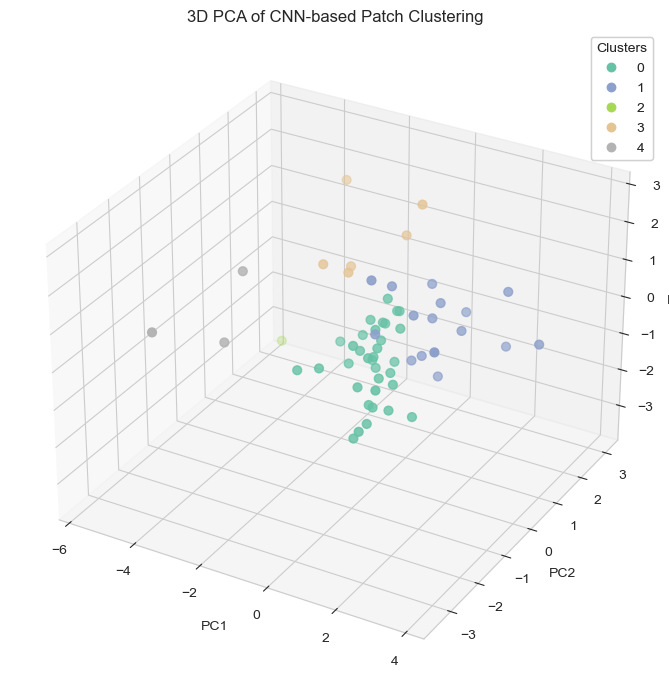

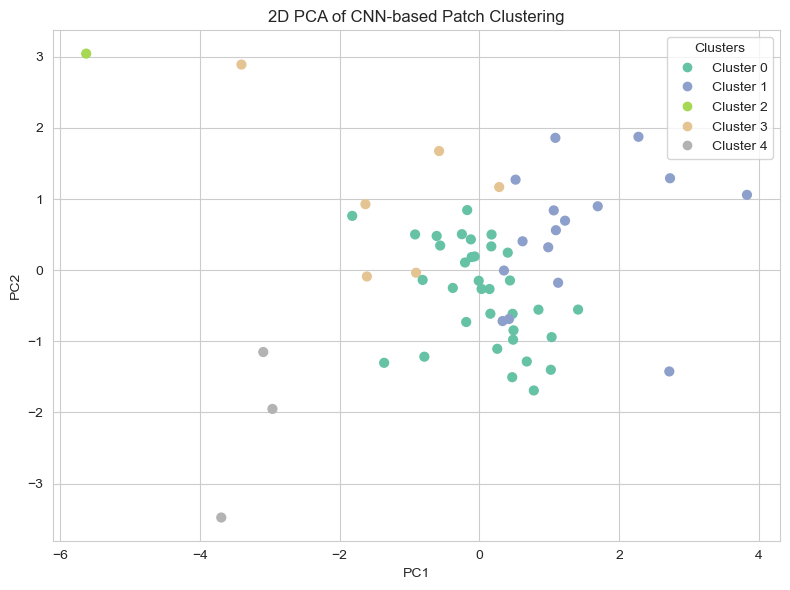

                PC1       PC2
feature_0  0.136513  0.485102
feature_1  0.080137  0.165901
feature_2  0.244245 -0.129147
feature_3 -0.181713  0.085610
feature_4 -0.010743 -0.332683
feature_5 -0.441609 -0.458096
feature_6 -0.264411  0.538318
feature_7 -0.434027  0.314089
feature_8  0.526216  0.061083
feature_9  0.389792  0.021105


In [64]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering



pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_final)
print(X_final)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_final)
n_clusters = 5 # 你可以试着调成 3～6
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# labels = kmeans.fit_predict(X_pca)
# clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
# labels = clustering.fit_predict(X)
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  # linkage 可以是 'ward', 'average',
labels = model.fit_predict(X_pca)  # X_pca 是你降维后的特征向量

# 画3D散点图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=labels, cmap='Set2', s=40)
ax.set_title("3D PCA of CNN-based Patch Clustering")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.tight_layout()
# plt.show()
# 每个主成分在原始特征上的权重（loading matrix）
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=[f'feature_{i}' for i in range(X_final.shape[1])]  # 用你自己的变量名更好
)

print(loadings)


# 如果聚类为2维，画散点图
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='Set2', s=40)
plt.title("2D PCA of CNN-based Patch Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)

# 添加图例
handles, _ = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in np.unique(labels)], title="Clusters")

plt.tight_layout()
plt.show()

# 每个主成分在原始特征上的权重（loading matrix）
loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=[f'feature_{i}' for i in range(X_final.shape[1])]  # 用你自己的变量名更好
)

print(loadings)

### 尝试选出合理的聚类算法

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:14

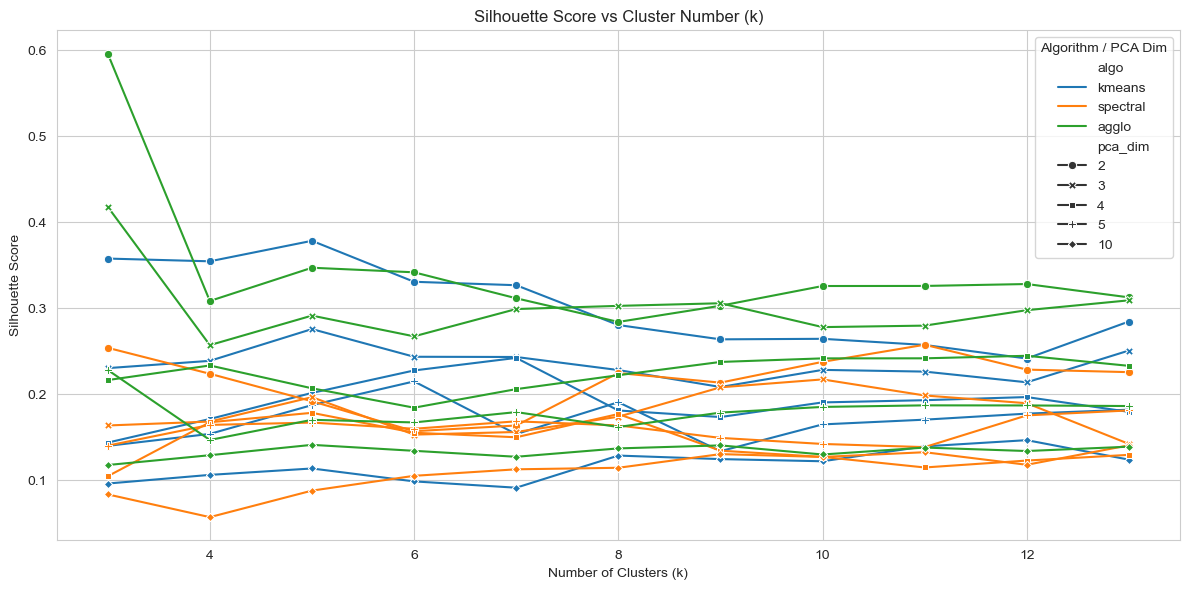

In [41]:

import seaborn as sns


algorithms = ['kmeans', 'spectral', 'agglo']
results = []

for algo in algorithms:
    for dim in [2, 3,4, 5, 10]:
        X_pca = PCA(n_components=dim).fit_transform(X_final)
        for k in range(3, 14):
            try:
                if algo == 'kmeans':
                    model = KMeans(n_clusters=k, random_state=42)
                elif algo == 'spectral':
                    model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
                elif algo == 'agglo':
                    model = AgglomerativeClustering(n_clusters=k, linkage='ward')

                labels = model.fit_predict(X_pca)
                score = silhouette_score(X_pca, labels)

                # 保存
                results.append({
                    'algo': algo,
                    'pca_dim': dim,
                    'k': k,
                    'score': score
                })

            except Exception as e:
                print(f"{algo}, PCA={dim}, k={k} failed: {e}")

df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='k', y='score', hue='algo', style='pca_dim', markers=True, dashes=False)
plt.title("Silhouette Score vs Cluster Number (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend(title="Algorithm / PCA Dim")
plt.grid(True)
plt.tight_layout()
plt.show()

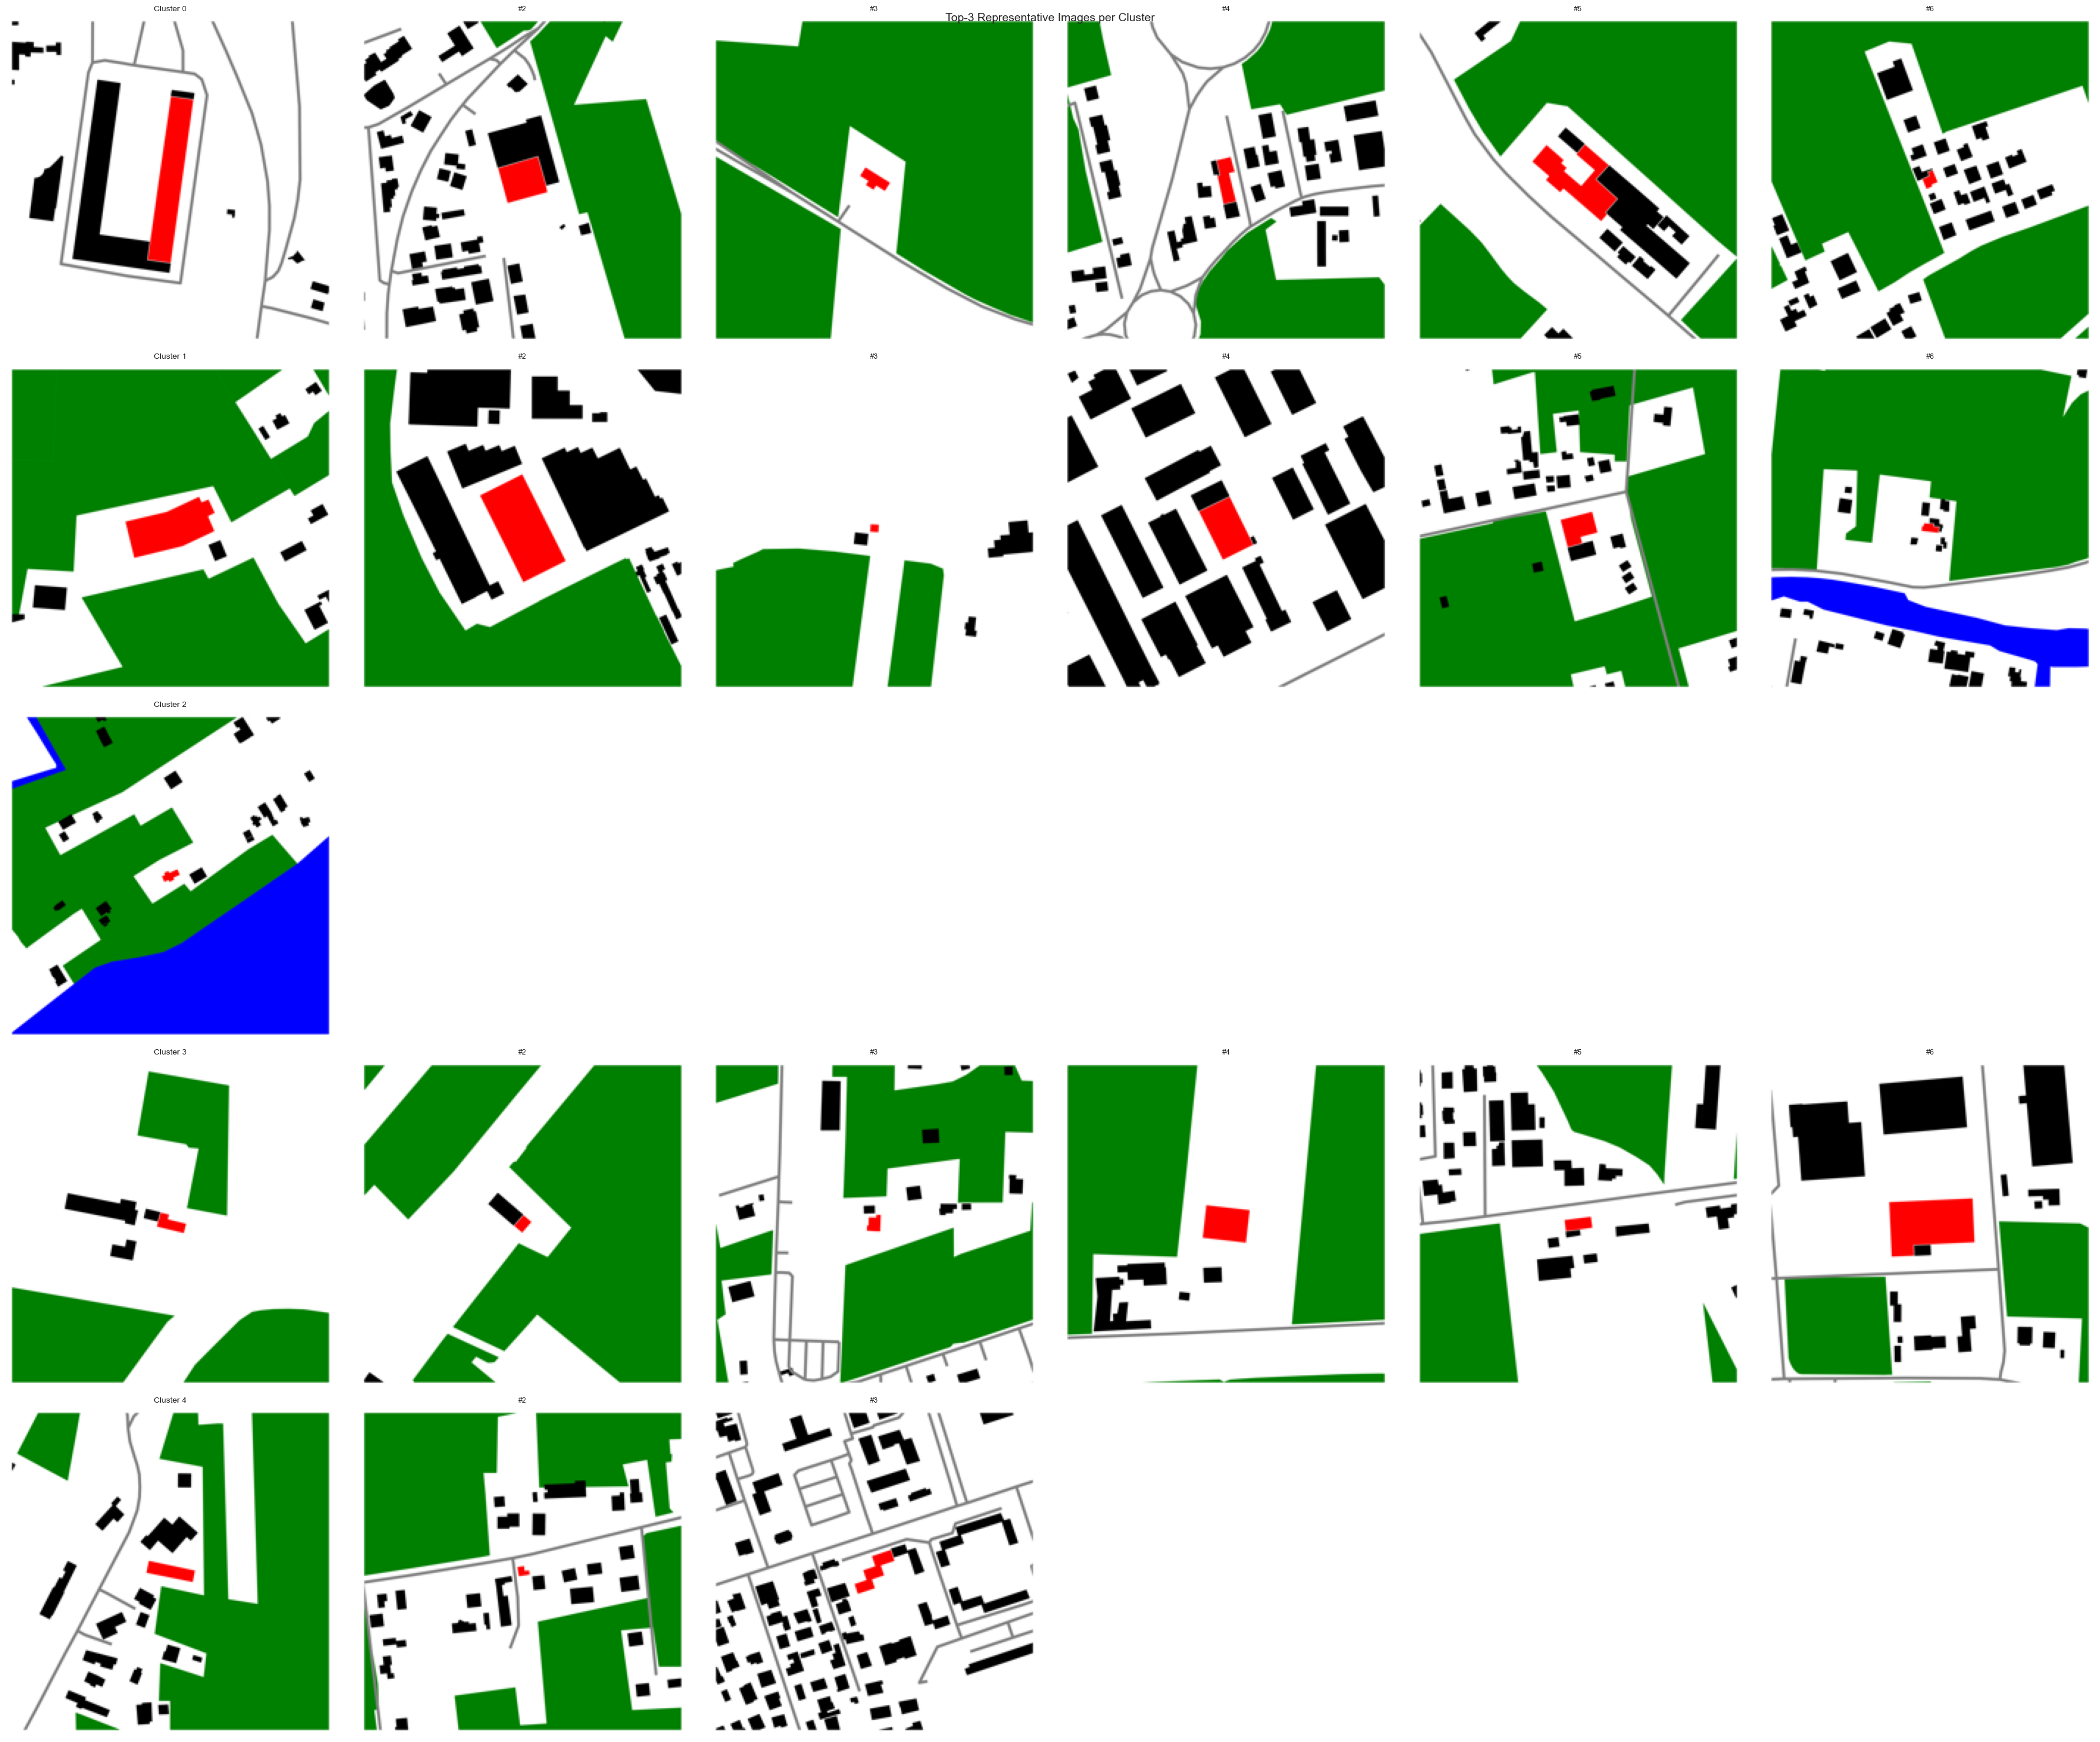

In [67]:
import matplotlib.pyplot as plt

topk = 6
representative_clusters = {}

for cluster_id in np.unique(labels):
    idx = np.where(labels == cluster_id)[0]
    cluster_points = X_pca[idx]
    # center = kmeans.cluster_centers_[cluster_id]
    center = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - center, axis=1)

    sorted_indices = idx[np.argsort(distances)[:topk]]
    representative_clusters[cluster_id] = sorted_indices

n_clusters = len(representative_clusters)

plt.figure(figsize=(topk * 6, n_clusters * 6))

for cluster_id, indices in representative_clusters.items():
    for rank, idx in enumerate(indices):
        plt_idx = cluster_id * topk + rank + 1  # subplot index
        plt.subplot(n_clusters, topk, plt_idx)
        img = img_list[idx]

        # 若图像归一化（0~1），需要乘回 255
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.axis("off")
        if rank == 0:
            plt.title(f"Cluster {cluster_id}", fontsize=10)
        else:
            plt.title(f"#{rank+1}", fontsize=9)

plt.suptitle("Top-3 Representative Images per Cluster", fontsize=14)
plt.tight_layout()
plt.show()


Outlier 图像的 CNN+语义特征向量：
[ 0.01091022 -0.33543739 -1.00337219  0.30954069  0.34544888 -0.18747192
  2.37577257  5.91526968 -1.52269892 -3.55693996]
43
(224, 224, 3)


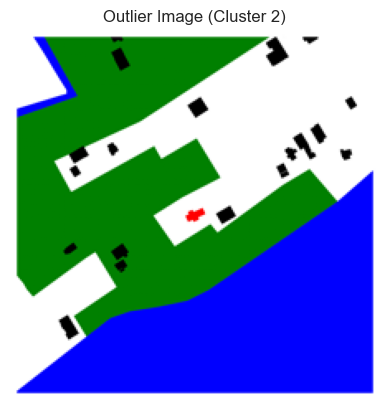

In [81]:
# 找出唯一类的 index（比如 label 为 5 的只有一个点）
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    if count == 1:
        outlier_label = label
        outlier_index = np.where(labels == label)[0][0]
        break

# 打印其特征
print("Outlier 图像的 CNN+语义特征向量：")
print(X_final[outlier_index])
print(outlier_index)
plt.imshow(img_list[outlier_index])
print(img_list[outlier_index].shape)
plt.title(f"Outlier Image (Cluster {outlier_label})")
plt.axis('off')
plt.show()

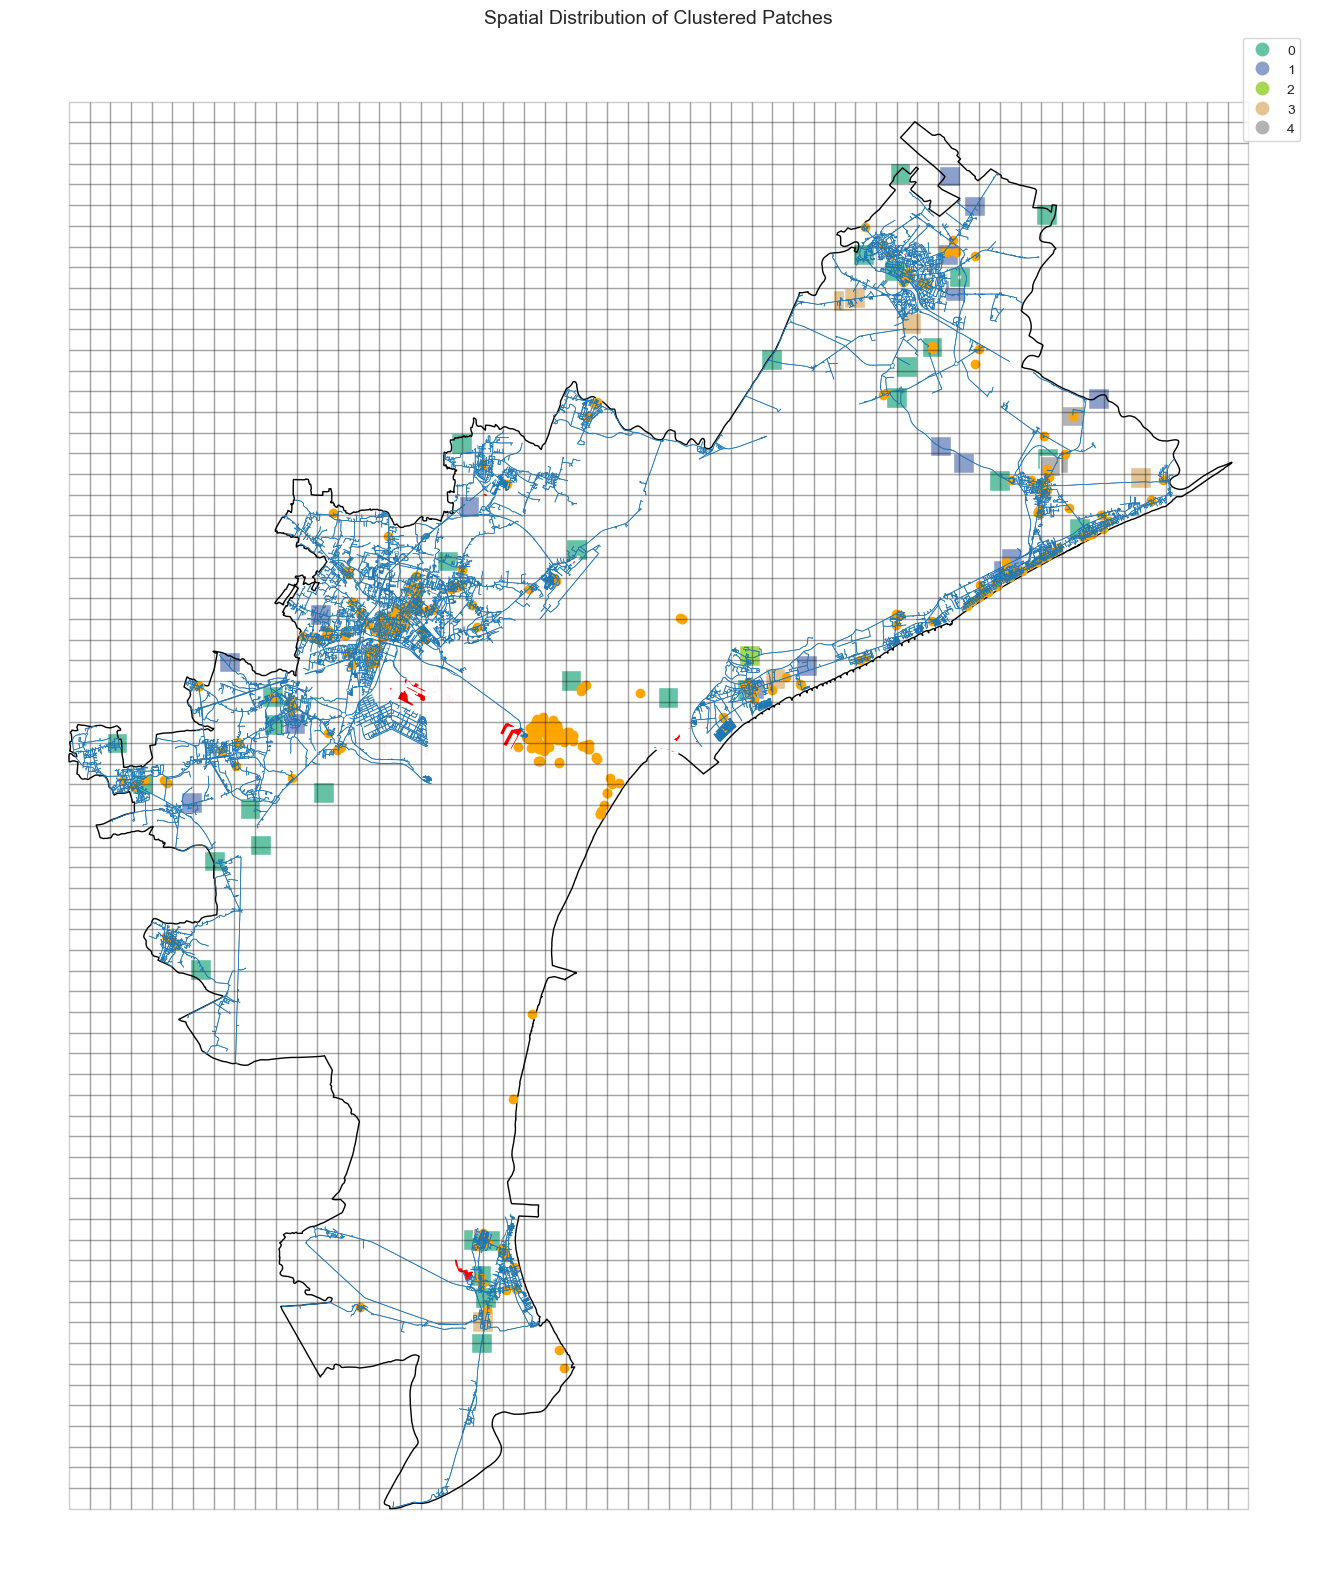

In [79]:
patches_with_gwr = patches_with_gwr.copy()
patches_with_gwr['cluster'] = labels  # 新增一列
import matplotlib.pyplot as plt

# 显示GWR的框架
fig, ax = plt.subplots(figsize=(20, 16))
patches_with_gwr.plot(column='cluster', cmap='Set2', categorical=True, legend=True, ax=ax)

ax.set_title("Spatial Distribution of Clustered Patches", fontsize=14)
ax.axis("off")
plt.tight_layout()
gdf_boundary=gpd.read_file("origin_data/00_Boundaries").to_crs(epsg=32632)
gdf_roads=gpd.read_file("origin_data/07_logistics_roads").to_crs(epsg=32632)
gdf_trans=gpd.read_file("origin_data/06_logistics_transportation").to_crs(epsg=32632)
gdf_retail=gpd.read_file("origin_data/08_supply_retail").to_crs(epsg=32632)
grid= gpd.read_file(r"processing_data\grid\grid_entropy.geojson")
gdf_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
gdf_roads.plot(ax=ax,linewidth=0.5)
gdf_trans.plot(ax=ax,color="red")
gdf_retail.plot(ax=ax,color="orange")
grid.plot(ax=ax,edgecolor="black",alpha=0.2,facecolor="none")
plt.show()
